In [4]:
### import modules

import os
import re
import numpy as np
import pandas as pd
from obspy import read, read_inventory, UTCDateTime
from obspy.signal.cross_correlation import correlation_detector
from scipy.signal import correlate
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime

In [2]:
# Cross-correlation function
def cross_correlate(waveform1, waveform2):
    correlation = correlate(waveform1, waveform2, mode='full')
    # Normalize the correlation to be between 0 and 1
    correlation_normalized = correlation / (np.linalg.norm(waveform1) * np.linalg.norm(waveform2))
    return correlation_normalized

In [5]:
### load data

events = np.loadtxt("../catalog/initial_LPE_picks", dtype = 'str')
stZ = read("../data/HHZ.D/*")
stN = read("../data/HHN.D/*")
stE = read("../data/HHE.D/*")
st = stE + stN + stZ
print(st)
inv = read_inventory("../data/Stations_Reykjanes2021_RR.xml",format='STATIONXML')
#print(events)

60 Trace(s) in Stream:

RR.SAND.00.HHE | 2024-01-01T00:00:01.189626Z - 2024-01-01T07:57:21.844626Z | 200.0 Hz, 5728132 samples
...
(58 other traces)
...
RR.SAND.00.HHZ | 2024-01-27T23:10:58.847573Z - 2024-01-28T00:00:01.577573Z | 200.0 Hz, 588547 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]


1 Trace(s) in Stream:
RR.SAND.00.HHE | 2024-01-14T06:29:01.767099Z - 2024-01-14T06:29:11.767099Z | 200.0 Hz, 2001 samples


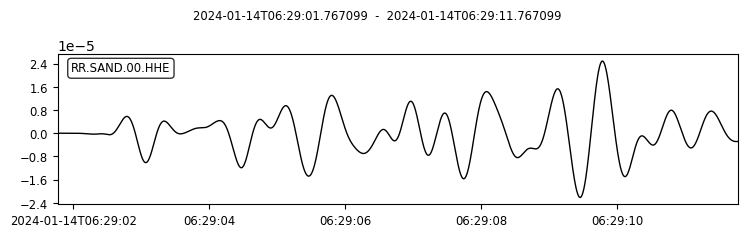

3 Trace(s) in Stream:
RR.SAND.00.HHE | 2024-01-13T23:59:59.999626Z - 2024-01-14T23:59:58.999626Z | 200.0 Hz, 17279801 samples
RR.SAND.00.HHN | 2024-01-13T23:59:59.999626Z - 2024-01-14T23:59:58.999626Z | 200.0 Hz, 17279801 samples
RR.SAND.00.HHZ | 2024-01-13T23:59:59.999626Z - 2024-01-14T23:59:58.999626Z | 200.0 Hz, 17279801 samples


C:\Users\leahr\miniconda3\envs\SeismicHazard\lib\site-packages\obspy\signal\cross_correlation.py:291: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(norm, out=norm)


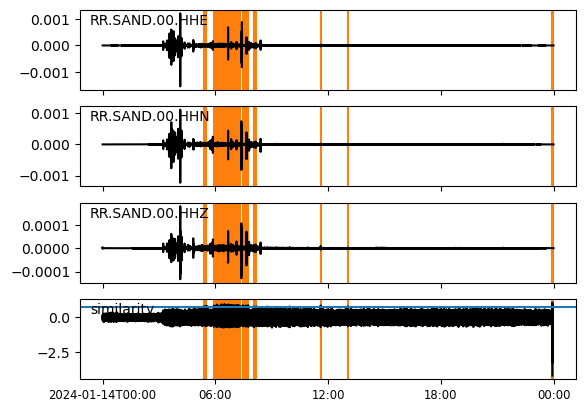

NameError: name 'datetime' is not defined

In [6]:
### cross correlation

events = np.loadtxt("../catalog/revised_LPE_picks", dtype = 'str')
st_cc = read("../data/HHE.D/*014")

tstart = events[11][0] + 'T' + events[11][1]
#print(events[-2][0], events[-2][1], st_cc)
template = st_cc.copy()
#print(UTCDateTime(tstart))

template.trim(UTCDateTime(tstart), UTCDateTime(tstart) + 10)
print(template)
template.detrend('demean')
template.detrend('linear')
template.taper(0.1)
template.remove_response(inventory=inv,output="VEL")
template.filter('bandpass', freqmin=0.5, freqmax=2)
template.plot();

stcc = st.copy()
stcc = stcc.merge(method = 1, fill_value='interpolate')
stcc.trim(UTCDateTime('2024-01-14 00:00:00'), UTCDateTime('2024-01-14 23:59:59'))
stcc.detrend('demean')
stcc.detrend('linear')
stcc.taper(0.1)
stcc.remove_response(inventory=inv,output="VEL")
stcc.filter('bandpass', freqmin=0.5, freqmax=2)

print(stcc)

height = 0.8  # similarity threshold
distance = 30  # distance between detections in seconds
detections, sims = correlation_detector(stcc, template, height, distance, plot=stcc)

###save the detections in a list (for visualization in snuffler)
detected_events = []

for key in detections:
    time_str = key['time'].isoformat()
    time_str = time_str.replace('Z', '')
    time_obj = datetime.datetime.fromisoformat(time_str)
    formatted_time_str = time_obj.strftime('%Y-%m-%d %H:%M:%S.%f')
    detected_events.append(formatted_time_str)

#print(detected_events)

out_path = '../catalog/014.txt'
# Write the list to the text file in the specified format
with open(out_path, 'w') as file:
    for idx, event in enumerate(detected_events, start=1):
        file.write(f"name = LPE_{idx}\n")
        file.write(f"time = {event}\n")
        file.write("--------------------------------------------\n")

In [14]:
### merging my files

# Directory where your files are stored
directory = '../catalog'
pattern = re.compile(r'^\d{3}\.txt$')

# Get a sorted list of files that match the pattern
files = sorted([f for f in os.listdir(directory) if pattern.match(f)])

output_file = '../catalog/cc_picks.txt'
continuous_name_counter = 1

with open(output_file, 'w') as outfile:
    for filename in files:
        with open(os.path.join(directory, filename), 'r') as infile:
            for line in infile:
                if line.startswith("name = LPE_"):
                    outfile.write(f"name = LPE_{continuous_name_counter}\n")
                    continuous_name_counter += 1
                else:
                    outfile.write(line)
        outfile.write("--------------------------------------------\n")

print(f"Full structure merged file saved as {output_file}")

output_file_timestamps = '../catalog/cc_LPE_times.txt'

with open(output_file_timestamps, 'w') as outfile:
    for filename in files:
        with open(os.path.join(directory, filename), 'r') as infile:
            for line in infile:
                if line.startswith("time = "):
                    outfile.write(line.split(" = ")[1])

print(f"Timestamps merged file saved as {output_file_timestamps}")


Full structure merged file saved as ../catalog/cc_picks.txt
Timestamps merged file saved as ../catalog/cc_LPE_times.txt


In [8]:
### cross correlate new events

# load new catalog
events = np.loadtxt("../catalog/cc_LPE_times.txt", dtype=str)
st = read("../data/HHE.D/*")
inv = read_inventory("../data/Stations_Reykjanes2021_RR.xml",format='STATIONXML')

event_list = []
for event in events:
    tstart = event[0] + 'T' + event[1]
    stcc2 = st.copy()
    stcc2.trim(UTCDateTime(tstart) - 1, UTCDateTime(tstart) + 5)

    stcc2.detrend('demean')
    stcc2.detrend('linear')
    stcc2.taper(0.1)
    stcc2.remove_response(inventory=inv,output="VEL")
    stcc2.filter("bandpass", freqmin = 0.5, freqmax = 5.0)
    event_list.append(stcc2)

    # Ensure all waveforms are the same length
    min_length = min(len(waveform) for waveform in event_list)
    waveforms = [waveform[:min_length] for waveform in event_list]

    # Create an empty correlation matrix
    num_waveforms = len(waveforms)
    correlation_matrix = np.zeros((num_waveforms, num_waveforms))

    # Compute cross-correlation for each pair of waveforms
    for i in range(num_waveforms):
        for j in range(num_waveforms):
            correlation = cross_correlate(waveforms[i], waveforms[j])
            # Using the maximum value of the normalized cross-correlation as the correlation metric
            correlation_matrix[i, j] = np.max(correlation)

    # Extract event times and convert to matplotlib date format
    event_times = [UTCDateTime(event[0] + 'T' + event[1]) for event in events]
    event_times_mpl = mdates.date2num([et.datetime for et in event_times])

    # Convert the correlation matrix to a DataFrame for better readability
    correlation_df = pd.DataFrame(correlation_matrix)

    # Display the correlation matrix
    print(correlation_df)

     0
0  1.0
         0        1
0  1.00000  0.92762
1  0.92762  1.00000
          0         1         2
0  1.000000  0.927620  0.727275
1  0.927620  1.000000  0.729692
2  0.727275  0.729692  1.000000
          0         1         2         3
0  1.000000  0.927620  0.727275  0.659623
1  0.927620  1.000000  0.729692  0.672052
2  0.727275  0.729692  1.000000  0.652109
3  0.659623  0.672052  0.652109  1.000000
          0         1         2         3         4
0  1.000000  0.927620  0.727275  0.659623  0.691886
1  0.927620  1.000000  0.729692  0.672052  0.729450
2  0.727275  0.729692  1.000000  0.652109  0.770644
3  0.659623  0.672052  0.652109  1.000000  0.559852
4  0.691886  0.729450  0.770644  0.559852  1.000000
          0         1         2         3         4         5
0  1.000000  0.927620  0.727275  0.659623  0.691886  0.690461
1  0.927620  1.000000  0.729692  0.672052  0.729450  0.686537
2  0.727275  0.729692  1.000000  0.652109  0.770644  0.589844
3  0.659623  0.672052  0.652

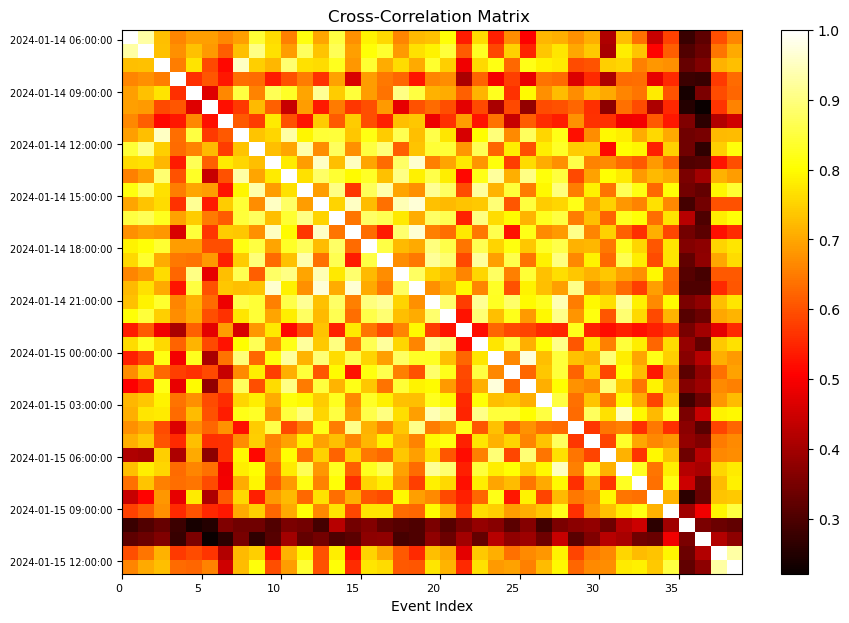

In [9]:
# Plot the correlation matrix
fig1 = plt.figure(figsize=(10, 8))
plt.imshow(correlation_matrix, cmap='hot', interpolation='nearest', aspect='auto', extent=[0, num_waveforms, max(event_times_mpl), min(event_times_mpl)])
plt.colorbar()
plt.title('Cross-Correlation Matrix ')
plt.xlabel('Event Index')
plt.gca().yaxis_date()
plt.gca().yaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))
plt.gcf().autofmt_xdate()
plt.tick_params(axis='y', which='major', labelsize=7)  # Adjust the font size here
plt.tick_params(axis='x', labelsize=8, rotation=0)
plt.show()

fig1.savefig("../figures/" + 'CrossCorr_allevents_1s')

In [10]:
### plot events in time

events = np.loadtxt("../catalog/cc_LPE_times.txt", dtype = 'str')

# Plotting the histogram
event_times = []
for event in events:
    times = event[0] + ' ' + event[1]
    event_times.append(times)
    
event_dates = [datetime.datetime.strptime(event, '%Y-%m-%d %H:%M:%S.%f') for event in event_times]
start_date = datetime.datetime(2024, 1, 1)
end_date = datetime.datetime(2024, 2, 1)
dates = [start_date + datetime.timedelta(days=i) for i in range((end_date - start_date).days)]
event_counts = [sum(1 for event in event_dates if event.date() == date.date()) for date in dates]

fig1 = plt.figure(figsize=(10, 8))

# plotting events from the 14th
january_14_events = [event for event in event_dates if event.date() == datetime.date(2024, 1, 14)]
hours = range(0, 24)
event_counts_hourly = [sum(1 for event in january_14_events if event.hour == hour) for hour in hours]

ax1 = fig1.add_subplot(211)
ax1.bar(hours, event_counts_hourly, width=0.8, align='center', edgecolor='black')
ax1.set_title('Number of Events detected by Cross Correlation per Hour on January 14, 2024', fontsize = 16)
ax1.set_xlabel('Hour of the Day', fontsize = 14)
ax1.set_ylabel('Number of Events', fontsize = 14)
ax1.set_ylim(0,20)
ax1.set_xticks(hours)
ax1.tick_params(axis='x', rotation=0)

# plotting events from the 14th
january_15_events = [event for event in event_dates if event.date() == datetime.date(2024, 1, 15)]
hours2 = range(0, 24)
event_counts_hourly2= [sum(1 for event in january_15_events if event.hour == hour) for hour in hours]

ax2 = fig1.add_subplot(212)
ax2.bar(hours2, event_counts_hourly2, width=0.8, align='center', edgecolor='black')
ax2.set_title('Number of Events detected by Cross Correlation per Hour on January 15, 2024', fontsize = 16)
ax2.set_xlabel('Hour of the Day', fontsize = 14)
ax2.set_ylabel('Number of Events', fontsize = 14)
ax2.set_ylim(0,20)
ax2.set_xticks(hours)
ax2.tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.savefig("../figures/" + "cc_events_over_time")
plt.close(fig1)

C:\Users\leahr\AppData\Local\Temp\ipykernel_3640\1937465083.py:29: MatplotlibDeprecationWarning: Passing the emit parameter of set_ylim() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax1.set_ylim(0,20,2)
C:\Users\leahr\AppData\Local\Temp\ipykernel_3640\1937465083.py:43: MatplotlibDeprecationWarning: Passing the emit parameter of set_ylim() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax2.set_ylim(0,20,2)
